In [32]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [4]:
file = "genres/genres/blues/blues.00000.wav"

# Generate Waveform

In [8]:
signal, sr = librosa.load(file, sr=22050)

In [12]:
signal

array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847], dtype=float32)

In [13]:
sr

22050

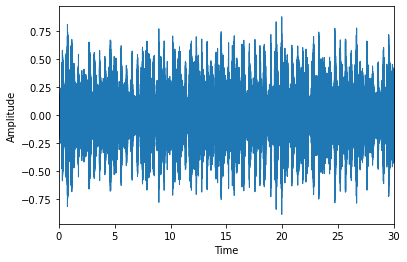

In [17]:
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# FFT to Spectrum

In [30]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

In [33]:
left_frequency = frequency[:len(frequency)//2]
left_magnitude = magnitude[:len(magnitude)//2]

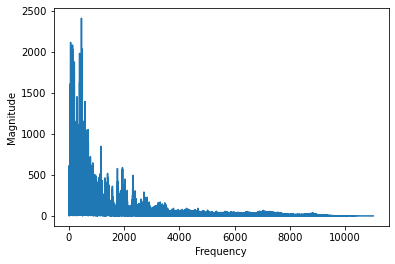

In [34]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()